In [39]:
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import time
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd

url = f'https://www.usi.at/de/angebot/#!/kurs/4241'
url_main = f'https://www.usi.at/de/angebot/#!/sportart'

page = requests.get(url)
page_main = requests.get(url_main)
#soup_main = BeautifulSoup(page_main.text, 'lxml')
#soup = BeautifulSoup(page.text, 'lxml') # funkt nicht

Get All Courses 

In [40]:
driver_main = webdriver.Chrome(ChromeDriverManager().install())
driver_main.get(url_main)
content_main = driver_main.page_source.encode('utf-8').strip()
time.sleep(3)

content_main = driver_main.page_source.encode('utf-8').strip()
soup_main = BeautifulSoup(content_main,"html.parser")

driver_main.quit()

/var/folders/2g/mmrh97td0m70h3qg8l_5gcbr0000gn/T/ipykernel_17666/146299116.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver_main = webdriver.Chrome(ChromeDriverManager().install())


In [41]:
# so hab ich begonnen: ul = soup_main.findAll('ul', attrs={'class':'course-list-subitems subitems course-overview ng-scope'})
course_name_list=[]
course_href_list=[]

ul = soup_main.find('ul', attrs={'class':'course-list-subitems subitems course-overview ng-scope'}) # notwendig, weil "ng-scope" 2x
li = ul.findAll('li', attrs={'class':'subitem ng-scope'}) 
for course in li:
    course_name_list.append(course.find('span').text) # NICHT li[course].find('span').text, weil course ist instance of li
    course_href_list.append(course.find('a').attrs['href']) # oder course_href = li[0].find('a').attrs['href']


get data from many courses

In [42]:
#create pandas df
df = pd.DataFrame(columns=["Kurs Name", "Kurs Nr", "Tag", "Zeit Von", "Zeit Bis", "Ort", "Limit", "Freie Plätze", "Preis I", "Preis II", "Preis III", "TryUSI"])

t = time.time()  # TIC

for index, num in enumerate(course_href_list):
    if index == 200:
        break
    driver = webdriver.Chrome(ChromeDriverManager().install())
    url = f"https://www.usi.at/de/angebot/{num}"
    driver.get(url)
    time.sleep(3)

    content = driver.page_source.encode('utf-8').strip()
    soup = BeautifulSoup(content,"html.parser")
    driver.quit()
    
    # get it in pandas 
    #l = []
    for li in soup.findAll('li', attrs={'class':'ng-scope ng-isolate-scope'}):
        kursname = li.find('h3').text.split("-") 
        table = li.find('table')
        tbody = li.find('tbody')
        td = tbody.find_all('td')
        row = [tr.text.split() for tr in td]
        try:
            if row[8][6] == 'TryUSI':
                finalrow = [kursname[0],row[0][0],row[1][0],row[2][0],row[2][2],row[4][0],row[6][0],row[7][0],row[8][1],row[8][8],row[8][14],"yes"]  # for  TryUSI
            if row[8][6] != 'TryUSI':
                finalrow = [kursname[0],row[0][0],row[1][0],row[2][0],row[2][2],row[4][0],row[6][0],row[7][0],row[8][1],row[8][7],row[8][12], "no"]  # for NOT TryUSI
        except IndexError:
            continue
        #l.append(finalrow)
        df.loc[len(df)] = finalrow

elapsed = time.time() - t  # TOC

df

/var/folders/2g/mmrh97td0m70h3qg8l_5gcbr0000gn/T/ipykernel_17666/1853444024.py:9: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


,Kurs Name,Kurs Nr,Tag,Zeit Von,Zeit Bis,Ort,Limit,Freie Plätze,Preis I,Preis II,Preis III,TryUSI
0,ACHTSAMKEITSTRAINING,707,DI,1030,1200,SPITALGASSE,25,1,52,80,104,no
1,AERIAL DANCE,218,DI,1415,1530,TENDLERGASSE,13,3,135,145,155,no
2,AERIAL DANCE,225,DO,1100,1215,TENDLERGASSE,13,0,135,145,155,no
3,AERIAL DANCE,2085,DO,1340,1455,TENDLERGASSE,13,4,135,145,155,no
4,AERIAL HOOP,2094,DO,1800,1930,TENDLERGASSE,16,9,150,160,170,no
...,...,...,...,...,...,...,...,...,...,...,...,...
765,ZUMBA,1412,DI,1330,1500,WU-PRATER,49,22,12,18,23,yes
766,ZUMBA,1790,DO,0915,1045,USZ2,33,6,12,18,23,yes
767,ZUMBA,1827,DO,1030,1200,WU-PRATER,49,27,12,18,23,yes
768,ZUMBA,1110,DO,1200,1307,WU-PRATER,49,15,9,13,17,yes


In [21]:
row[1][0]

IndexError: list index out of range

In [43]:
elapsed

1138.3918170928955

data types checken

In [44]:
df["Kurs Name"] = df["Kurs Name"].astype(str)
df["Kurs Nr"] = df["Kurs Nr"].astype(int)
df["Tag"] = df["Tag"].astype(str)
df["Zeit Von"] = df["Zeit Von"].astype(int)
df["Zeit Bis"] = df["Zeit Bis"].astype(int)
df["Ort"] = df["Ort"].astype(str)
df["Limit"] = df["Limit"].astype(int)
df["Freie Plätze"] = df["Freie Plätze"].astype(int)
df["Preis I"] = df["Preis I"].astype(float)
df["Preis II"] = df["Preis II"].astype(float)
df["Preis III"] = df["Preis III"].astype(float)

df.dtypes

Kurs Name        object
Kurs Nr           int64
Tag              object
Zeit Von          int64
Zeit Bis          int64
Ort              object
Limit             int64
Freie Plätze      int64
Preis I         float64
Preis II        float64
Preis III       float64
TryUSI           object
dtype: object

Während TryUSI müssen die Daten bereinigt werden

In [21]:
# wenn bei Preis III TryUSI steht, lösche row
df.drop(df.index[df['Preis III'] == 'TryUSI'], inplace=True)

Export CSV

In [21]:
# df.to_csv('USI_data_test.csv', index=False)

Import CSV

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("USI_data_test.csv")
df

,Kurs Name,Kurs Nr,Tag,Zeit Von,Zeit Bis,Ort,Limit,Freie Plätze,Preis I,Preis II,Preis III,TryUSI
0,ACHTSAMKEITSTRAINING,707,DI,1030,1200,SPITALGASSE,25,1,52.0,80.0,104.0,no
1,AERIAL DANCE,218,DI,1415,1530,TENDLERGASSE,13,3,135.0,145.0,155.0,no
2,AERIAL DANCE,225,DO,1100,1215,TENDLERGASSE,13,0,135.0,145.0,155.0,no
3,AERIAL DANCE,2085,DO,1340,1455,TENDLERGASSE,13,4,135.0,145.0,155.0,no
4,AERIAL HOOP,2094,DO,1800,1930,TENDLERGASSE,16,9,150.0,160.0,170.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...
765,ZUMBA,1412,DI,1330,1500,WU-PRATER,49,22,12.0,18.0,23.0,yes
766,ZUMBA,1790,DO,915,1045,USZ2,33,6,12.0,18.0,23.0,yes
767,ZUMBA,1827,DO,1030,1200,WU-PRATER,49,27,12.0,18.0,23.0,yes
768,ZUMBA,1110,DO,1200,1307,WU-PRATER,49,15,9.0,13.0,17.0,yes


Prepare Data
1. Deal "TryUSI"

In [2]:
df["Preis I"] = np.where(df["TryUSI"] == "yes", df["Preis I"]*3, df["Preis I"])
df["Preis II"] = np.where(df["TryUSI"] == "yes", df["Preis II"]*3, df["Preis II"])
df["Preis III"] = np.where(df["TryUSI"] == "yes", df["Preis III"]*3, df["Preis III"])
df["TryUSI"] = "no"
df

,Kurs Name,Kurs Nr,Tag,Zeit Von,Zeit Bis,Ort,Limit,Freie Plätze,Preis I,Preis II,Preis III,TryUSI
0,ACHTSAMKEITSTRAINING,707,DI,1030,1200,SPITALGASSE,25,1,52.0,80.0,104.0,no
1,AERIAL DANCE,218,DI,1415,1530,TENDLERGASSE,13,3,135.0,145.0,155.0,no
2,AERIAL DANCE,225,DO,1100,1215,TENDLERGASSE,13,0,135.0,145.0,155.0,no
3,AERIAL DANCE,2085,DO,1340,1455,TENDLERGASSE,13,4,135.0,145.0,155.0,no
4,AERIAL HOOP,2094,DO,1800,1930,TENDLERGASSE,16,9,150.0,160.0,170.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...
765,ZUMBA,1412,DI,1330,1500,WU-PRATER,49,22,36.0,54.0,69.0,no
766,ZUMBA,1790,DO,915,1045,USZ2,33,6,36.0,54.0,69.0,no
767,ZUMBA,1827,DO,1030,1200,WU-PRATER,49,27,36.0,54.0,69.0,no
768,ZUMBA,1110,DO,1200,1307,WU-PRATER,49,15,27.0,39.0,51.0,no


In [47]:
# df['Zeit Von'] = pd.to_timedelta(df['Zeit Von']//100 * 60 + df['Zeit Von'] % 100, unit='m')
# df['Zeit Bis'] = pd.to_timedelta(df['Zeit Bis']//100 * 60 + df['Zeit Bis'] % 100, unit='m')

In [48]:
df

,Kurs Name,Kurs Nr,Tag,Zeit Von,Zeit Bis,Ort,Limit,Freie Plätze,Preis I,Preis II,Preis III,TryUSI
0,ACHTSAMKEITSTRAINING,707,DI,1030,1200,SPITALGASSE,25,1,52.0,80.0,104.0,no
1,AERIAL DANCE,218,DI,1415,1530,TENDLERGASSE,13,3,135.0,145.0,155.0,no
2,AERIAL DANCE,225,DO,1100,1215,TENDLERGASSE,13,0,135.0,145.0,155.0,no
3,AERIAL DANCE,2085,DO,1340,1455,TENDLERGASSE,13,4,135.0,145.0,155.0,no
4,AERIAL HOOP,2094,DO,1800,1930,TENDLERGASSE,16,9,150.0,160.0,170.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...
765,ZUMBA,1412,DI,1330,1500,WU-PRATER,49,22,36.0,54.0,69.0,no
766,ZUMBA,1790,DO,915,1045,USZ2,33,6,36.0,54.0,69.0,no
767,ZUMBA,1827,DO,1030,1200,WU-PRATER,49,27,36.0,54.0,69.0,no
768,ZUMBA,1110,DO,1200,1307,WU-PRATER,49,15,27.0,39.0,51.0,no


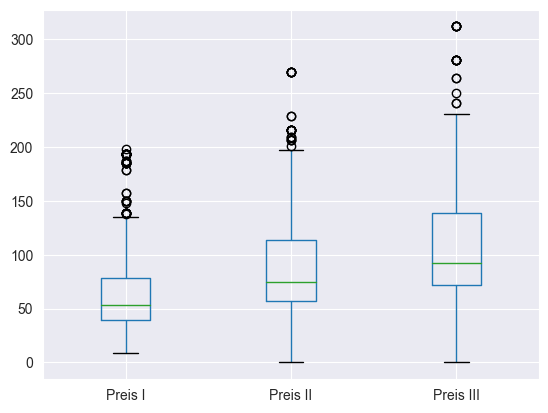

In [3]:
boxplot = df.boxplot(column=['Preis I', 'Preis II', 'Preis III'])

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# create a feature matrix and target vector
X = df[['Zeit Von', 'Zeit Bis']]
y = df['Freie Plätze']

# create a polynomial features object
poly_features = PolynomialFeatures(degree=5)

# transform the feature matrix
X_poly = poly_features.fit_transform(X)

# create a regression model
regressor = LinearRegression()
regressor.fit(X, y)

# create a polynomial regression model
regressor_poly = LinearRegression()
regressor_poly.fit(X_poly, y)

# use the model to predict the best time to start a new course
best_start_time = regressor.predict([[0, 0]])

# use the model to predict the best time to start a new course
best_start_time_poly = regressor_poly.predict(poly_features.fit_transform([[0, 0]]))

print('Linear: The best time to start a new course is:', best_start_time)
print('Poly: The best time to start a new course is:', best_start_time)

Linear: The best time to start a new course is: [4.73332401]
Poly: The best time to start a new course is: [4.73332401]


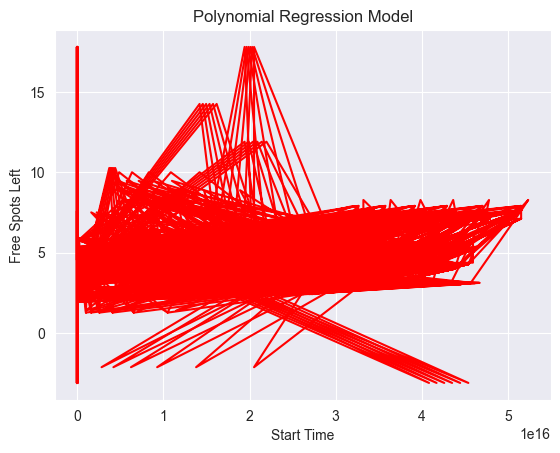

In [10]:
# import packages
import matplotlib.pyplot as plt

# plot the regression line
plt.plot(X_poly, regressor_poly.predict(X_poly), color='red')

# add labels
plt.title('Polynomial Regression Model')
plt.xlabel('Start Time')
plt.ylabel('Free Spots Left')

# show the plot
plt.show()

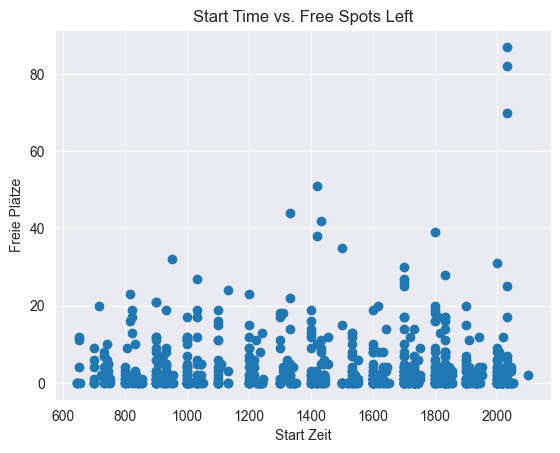

In [7]:
# import packages
import matplotlib.pyplot as plt

data =df

# drop rows with start time of 0
# data = df.drop(df[df['Freie Plätze'] == 0].index)

# plot the data points
plt.scatter(data['Zeit Von'], data['Freie Plätze'])

# add labels
plt.title('Start Time vs. Free Spots Left')
plt.xlabel('Start Zeit')
plt.ylabel('Freie Plätze')

# show the plot
plt.show()

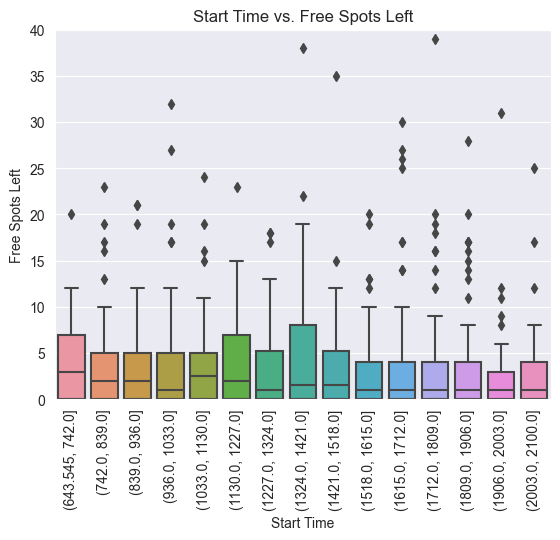

In [11]:
import seaborn as sns

fig, ax = plt.subplots()

# cut start time data into bins of size 15
bins = pd.cut(data['Zeit Von'], bins=(21-6))

# create a boxplot
sns.boxplot(x=bins, y=data['Freie Plätze'])

# add labels
plt.title('Start Time vs. Free Spots Left')
plt.xlabel('Start Time')
plt.ylabel('Free Spots Left')
ax.set_ylim(ymin=0, ymax=40)

# rotate x axis labels
plt.xticks(rotation=90)

# show the plot
plt.show()

# History

Get data from one course

In [16]:
driver = webdriver.Chrome(ChromeDriverManager().install())
url="https://www.usi.at/de/angebot/#!/kurs/4241"
driver.get(url)
time.sleep(3)

content = driver.page_source.encode('utf-8').strip()
soup = BeautifulSoup(content,"html.parser")
#for ul in soup.findAll('ul', attrs={'class':'ng-scope ng-isolate-scope'}):
#    print(str(ul))
#print(soup)
driver.quit()


/var/folders/2g/mmrh97td0m70h3qg8l_5gcbr0000gn/T/ipykernel_6780/547130436.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


<html class="js no-mobile desktop no-ie chrome chrome104 de-section angebot-section gradient rgba opacity textshadow multiplebgs boxshadow borderimage borderradius cssreflections csstransforms csstransitions no-touch retina fontface w-1200 gt-240 gt-320 gt-480 gt-640 gt-768 gt-800 gt-1024 lt-1280 lt-1440 lt-1680 lt-1920 no-portrait landscape domloaded" id="index-page" lang="de"><head><style type="text/css">[uib-typeahead-popup].dropdown-menu{display:block;}</style><style type="text/css">.uib-time input{width:50px;}</style><style type="text/css">[uib-tooltip-popup].tooltip.top-left > .tooltip-arrow,[uib-tooltip-popup].tooltip.top-right > .tooltip-arrow,[uib-tooltip-popup].tooltip.bottom-left > .tooltip-arrow,[uib-tooltip-popup].tooltip.bottom-right > .tooltip-arrow,[uib-tooltip-popup].tooltip.left-top > .tooltip-arrow,[uib-tooltip-popup].tooltip.left-bottom > .tooltip-arrow,[uib-tooltip-popup].tooltip.right-top > .tooltip-arrow,[uib-tooltip-popup].tooltip.right-bottom > .tooltip-arrow,[

In [17]:
#li
l = []
for li in soup.findAll('li', attrs={'class':'ng-scope ng-isolate-scope'}):
    kursname = li.find('h3').text.split("-") 
    table = li.find('table')
    tbody = li.find('tbody')
    td = tbody.find_all('td')
    row = [tr.text.split() for tr in td]
    finalrow = [kursname[0],row[0][0],row[1][0],row[2][0],row[2][2],row[4][0],row[6][0],row[7][0],row[8][1],row[8][7],row[8][12]]
    l.append(finalrow)

df = pd.DataFrame(l, columns=["Kurs Name", "Kurs Nr", "Tag", "Zeit Von", "Zeit Bis", "Ort", "Limit", "Freie Plätze", "Preis I", "Preis II", "Preis III"])
df
# x0 = Kurs Name 
# 0 = Kurs Nr. 
# 1 = Tag
# 2[0] = Zeit von 
# 2[2] = Zeit bis
# 4 = Ort ?
# 6 = Limit
# 7 = Freie Plätze
# 8[1] = Preis I
# 8[7] = Preis II
# 8[12] = Preis III

,Kurs Name,Kurs Nr,Tag,Zeit Von,Zeit Bis,Ort,Limit,Freie Plätze,Preis I,Preis II,Preis III
0,TANZSCHULE KRAML,639,DI,1730,1900,KUNDMANN,48,18,66,66,88
1,TANZSCHULE KRAML,1634,DO,1730,1900,KUNDMANN,48,17,66,66,88
2,TANZSCHULE KRAML,640,DI,1900,2030,KUNDMANN,48,1,58,58,79
3,TANZSCHULE KRAML,641,DI,2030,2200,KUNDMANN,48,21,66,66,88
4,TANZSCHULE KRAML,642,MI,1900,2030,KUNDMANN,60,34,66,66,88
5,TANZSCHULE KRAML,1633,MI,2030,2200,KUNDMANN,48,0,58,58,79
6,TANZSCHULE KRAML,1635,DO,1900,2030,KUNDMANN,48,1,58,58,79
7,TANZSCHULE KRAML,1636,DO,2030,2200,KUNDMANN,48,39,66,66,88


Use that data! <br>
Anm.: Für die Preise lösche ich duplicates von "Kurs Name", weil oft die Kurse gleich viel kosten und somit kein Bias entsteht.

In [29]:
import matplotlib as mpl
df

,Kurs Name,Kurs Nr,Tag,Zeit Von,Zeit Bis,Ort,Limit,Freie Plätze,Preis I,Preis II,Preis III
1,AERIAL DANCE,225,DI,1600,1715,TENDLERGASSE,13,0,110,120,130
2,AERIAL DANCE,218,DO,1100,1215,TENDLERGASSE,12,4,110,120,130
3,AERIAL HAMMOCK ACROBATICS,222,DO,1340,1455,TENDLERGASSE,13,4,110,120,130
4,AERIAL HOOP,193,DI,1230,1345,TENDLERGASSE,16,2,120,130,140
5,AERIAL PILATES,213,DO,0945,1045,TENDLERGASSE,13,0,110,120,130


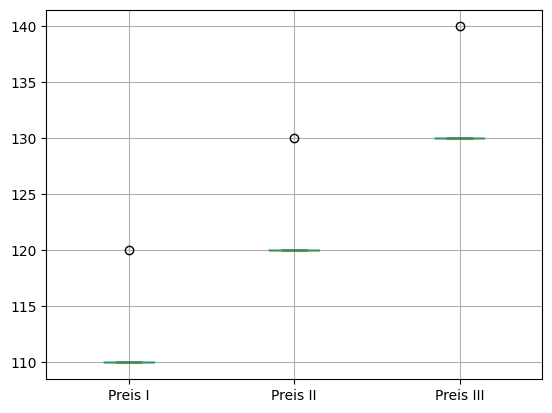

In [40]:
# Preis -> del duplicates
df.drop_duplicates(subset=['Kurs Name'])
boxplot = df.boxplot(column=['Preis I', 'Preis II', 'Preis III'])